In [22]:
import pandas as pd
import numpy as np
from pylab import rcParams
import datetime as dt
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates 

from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from collections import Counter

I decided to take a class-based approach to the functions I defined for this project. 

In [87]:
class Stats:
        
    
    def newVariables(df):
        #calculates the percentage of COVID tests that came back as positive for a single day.
        df['positivityRate%'] = (df['positiveIncrease']/df['totalTestResultsIncrease'])*100
        #calculates the total amount of COVID deaths in the previous seven days
        df['deathIncreaseSevenDay'] = df['deathIncrease'].rolling(7).sum().shift(-6)
        #calculates the average amount of COVID deaths in the previous seven days
        df['deathIncreaseSDRA'] = df['deathIncrease'].rolling(7).mean().shift(-6)
        #calculates the amount of positive cases divided by the amount of COVID deaths
        df['caseFatalityRate'] = df['death'] / df['positive']
        #calculates the average weekly death toll among the last five weeks 
        df['7 day total avg 5w'] = df['deathIncreaseSevenDay'].rolling(5).mean().shift(-4)
        #calculates the percentage that the death increase seven day rolling average changed
        df['% increase diSDRA'] = 100 * round(df['deathIncreaseSDRA']/df['deathIncreaseSDRA'].shift(-1) - 1, 3)
        #calculates the percentage that the average weekly death toll among the last five weeks changed
        df['% increase diSD'] = 100 * round(df['7 day total avg 5w']/df['7 day total avg 5w'].shift(-1) - 1, 3)
        #calculates the percentage that the percent change of the death increase seven day rolling average changed
        df['% increase %i diSDRA'] = 100 * round(df['% increase diSDRA']/df['% increase diSDRA'].shift(-1) - 1, 3)
        #calculates the seven day rolling average of new cases
        df['positiveIncreaseSDRA'] = df['positiveIncrease'].rolling(7).mean().shift(-6)
        #converts the date to a more human-friendly format
        df['date'] = [datetime.strptime(str(x), '%Y%m%d').strftime('%m/%d/%Y') for x in df['date']]
        return df

    def stateCsv(state):
        #Pulls data from the covidtracking.com project. Unfortunately, this project stopped updating its figures March 7, 2021
        df = pd.read_csv(f"https://api.covidtracking.com//v1/states/{state}/daily.csv")
        #Adds the variables defined in the newVariables function.
        df = Stats.newVariables(df)
        return df
    
    def usaCsv():
        #The covidtracking.com API has a single dedicated table for the entire USA
        usa = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv')
        #Adds the variables defined in the newVariables function.
        usa = Stats.newVariables(usa)
        return usa
    
    
    #I used a different source for global cases provided by COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University
    def world_csv_deaths(str):
        world_his_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        df = world_his_deaths[(world_his_deaths['Country/Region'] == str) & world_his_deaths['Province/State'].isnull() ]
        return df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"],
                var_name="Date",
                value_name="Deaths")

    #Since there is a separate CSV for case numbers and death statistics, I built separate functions to work with each source
    def world_csv_cases(str):
        world_his_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        df = world_his_cases[(world_his_cases['Country/Region'] == str) & world_his_cases['Province/State'].isnull() ]
        return df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"],
                    var_name="Date",
                    value_name="Cases")

    #I wrote this function to combine the two world sources into a single dataframe. 
    def worldCsv(str):
        df = Stats.world_csv_cases(str)
        df2 = Stats.world_csv_deaths(str)
        df['Deaths'] = df2['Deaths']
        #Calculates the case fatality rate based on the country's cases count and death count
        df['CaseFatalityRate'] = df['Deaths']/df['Cases']
        return df

    #Creates an easy to read line graph using an input of area (state or country), the variable one wants to measure, 
    #and a time horizon going back a specific amount of months, weeks, and days.
    def plotIt(area, column, mths, wks, ds):
        try:
            df = Stats.stateCsv(area)
            df = df[::-1]
        except:
            df = Stats.worldCsv(area)
            df['date'] = df['Date']
        finally:
            plt.figure(figsize = (18, 6))
            #Uses input of months, weeks, and days to determine the start date of the graph
            plt.plot(df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])]['date'] , 
                              df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])][column])
            #Modifies x-axis label size and frequency to increase legibility. Also rotates labels.  
            plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
            plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
            #Dynamically labels the graph depending on if the area examined is a whole name or abbreviation.
            #If area is an abbreviation, it is capitalized. 
            if len(area) <= 3:
                plt.title(f"COVID {column} in {area.upper()}", size = 15)
            else:
                plt.title(f"COVID {column} in {area}", size = 15)
            plt.xlabel('Date', size = 15)
            #Labels y-axis based on variable examined 
            plt.ylabel(column, size = 15)
            #Adds a grid for ease of use and starts the plot at (0,0)
            plt.grid()
            plt.margins(0)
            
    #Creates two overlaying line graphs with an input of the area one wants to analyze, the two variables, and the 
    #amount of months, weeks, and days ago one wants to see the data for. 
    def plotOverlay(area, column1, column2, mths, wks, ds):
        try:
            df = Stats.stateCsv(area)
            df = df[::-1]
        except:
            df = Stats.worldCsv(area)
            df['date'] = df['Date']
        finally:
            plt.figure(figsize = (18, 5))
            #Modifies x-axis label size and frequency to increase legibility. Also rotates labels. 
            plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
            plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
            #Adds a grid for ease of use
            plt.grid()
            #Starts plot at (0,0)
            plt.margins(0)
            #Uses input of months, weeks, and days to determine the start date of the graph
            plt.plot(df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])]['date'] , 
                              df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])][column1])

            plt.plot(df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])]['date'] , 
                              df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])][column2])
            #Creates title based on two input variables and area
            plt.title(f"COVID {column1} and {column2} in {area.upper()}", size = 15)
            plt.xlabel('Date', size = 15)
            #Creates legend based on the two input variables
            plt.legend([column1, column2])
            
    #Creates a scatterplot of a single variable with a linear regression model overlayed. Also has a variable for a start_date. 
    def regressionLine(area, start_date, column):
        try:
            df = Stats.stateCsv(area)
        except:
            df = Stats.worldCsv(area)
            df['date'] = df['Date']
        finally:
            df = df.fillna(0)
            df['date'] = pd.to_datetime(df['date'])
            #Uses start_date input to convert the date variable into the amount of days starting from the date
            basedate = datetime.strptime(start_date, '%m/%d/%Y')
            x = df
            df['date'] = df.apply(lambda x: (x.date - basedate).days, axis=1)
            #Slices data so that it only contains data from the start date onwards
            df = df[df['date'] >= 0].reset_index()
            reg = linear_model.LinearRegression()
            #This creates the linear regression line
            reg.fit(df[['date']], df[column])
            plt.scatter(df.date, df[column], color = 'red', marker = '+')
            plt.plot(df.date, reg.predict(df[['date']]), color = 'blue')
            #Titles the graph differently depending if it is a US state or another country
            try:
                plt.title(f"COVID {column} in {df['state'][0]}")
            except:
                plt.title(f"COVID {column} in {df['Country/Region'][0]}")
            #Creates an x-axis label that is dynamically programmed based on the start date
            plt.xlabel(f"Days since {basedate}")
            #Creates an y-axis label is dynamically programmed based on the variable chosen.
            plt.ylabel(column)
            plt.grid()
            plt.margins(0)
            #prints out the coefficient of determination, slope, and sample size of the regression
            print(f"r2 = {r2_score(df[column], reg.predict(df[['date']]) )}, slope = {reg.coef_}, n={len(df)}")
        
    #Uses a linear regression model to predict a variable at a later date. Takes a start_point variable to 
    #change scope.
    def predictor(area, column, start_point, future_date):
        try:
            df = Stats.stateCsv(area)
        except:
            df = Stats.worldCsv(area)
            df['date'] = df['Date']
        finally:
            df = df.fillna(0)
            df['date'] = pd.to_datetime(df['date'])
            #Uses start_date input to convert the date variable into the amount of days starting from the date
            basedate = datetime.strptime(start_point, '%m/%d/%Y')
            x = df
            df['date'] = df.apply(lambda x: (x.date - basedate).days, axis=1)
            #Slices data so that it only contains data from the start date onwards
            df = df[df['date'] >= 0].reset_index()
            reg = linear_model.LinearRegression()
            reg.fit(df[['date']], df[column])
            value = datetime.strptime(future_date, '%m/%d/%Y') - basedate
            #Also prints out the coefficient of determination, slope of regression, and sample size.
            print(f"r2 = {r2_score(df[column], reg.predict(df[['date']]) )}, slope = {reg.coef_}, n={len(df)}")
            return reg.predict([[value.days]])[0]


usa = Stats.usaCsv()
    

National COVID tracking data pulled from covidtracking.com API. Including custom variables.

In [6]:
usa.head(15)

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hash,positivityRate%,deathIncreaseSevenDay,deathIncreaseSDRA,caseFatalityRate,7 day total avg 5w,% increase diSDRA,% increase diSD,% increase %i diSDRA,positiveIncreaseSDRA
0,03/07/2021,56,28756184.0,74582825.0,11808.0,40212.0,878613.0,8137.0,45475.0,2801.0,...,74952fef2e04125e96bbf3007726bc3e64a6a6d8,3.550319,11901.0,1700.142857,0.017914,12417.8,-1.8,-2.7,28.6,57856.428571
1,03/06/2021,56,28714654.0,74450990.0,11783.0,41401.0,877887.0,8409.0,45453.0,2811.0,...,21a596203ad2c78f4e54d1e69967caf126a2a5a7,4.193944,12113.0,1730.428571,0.017911,12756.2,-1.4,-3.0,-300.0,59687.714286
2,03/05/2021,56,28654639.0,74307155.0,12213.0,42541.0,877384.0,8634.0,45373.0,2889.0,...,a35ea4289cec4bb55c9f29ae04ec0fd5ac4e0222,3.943266,12280.0,1754.285714,0.017890,13154.8,0.7,-2.7,-106.8,61292.000000
3,03/04/2021,56,28585852.0,74035238.0,12405.0,44172.0,874603.0,8970.0,45293.0,2973.0,...,a19ad6379a653834cbda3093791ad2c3b9fab5ff,4.116132,12200.0,1742.857143,0.017855,13518.8,-10.3,-3.1,-inf,62159.142857
4,03/03/2021,56,28520365.0,73857281.0,11778.0,45462.0,873073.0,9359.0,45214.0,3094.0,...,9e1d2afda1b0ec243060d6f68a7134d011c0cb2a,4.750941,13595.0,1942.142857,0.017835,13946.0,0.0,-1.5,-100.0,63598.857143
5,03/02/2021,56,28453529.0,73590280.0,11196.0,46388.0,870901.0,9465.0,45084.0,3169.0,...,d09d1f506dacacd07f11102ddf356ffc29bbaeb6,4.037755,13593.0,1941.857143,0.017791,14156.8,-3.6,-1.9,-inf,64516.285714
6,03/01/2021,56,28399281.0,73334501.0,11748.0,46738.0,869030.0,9595.0,44956.0,3171.0,...,b8084497a1216c1ba4e391d7496b7c0ee669cffa,4.165829,14106.0,2015.142857,0.017764,14435.2,0.0,-0.5,-100.0,66638.714286
7,02/28/2021,56,28351189.0,73216424.0,11708.0,47352.0,868006.0,9802.0,44907.0,3245.0,...,c7cfdf3c2bf7472966bada1560de5d2d7a30277e,3.858858,14100.0,2014.285714,0.017750,14506.6,-1.6,-0.4,-23.8,67272.714286
8,02/27/2021,56,28296840.0,73012825.0,11731.0,48871.0,867127.0,10114.0,44875.0,3335.0,...,b1154e8002e47ec585f769adf5ceecaa53dc8cbb,4.304368,14336.0,2048.000000,0.017747,14559.4,-2.1,1.2,-4.5,67894.571429
9,02/26/2021,56,28225595.0,72807735.0,11945.0,51112.0,865699.0,10466.0,44791.0,3466.0,...,24286d9bbff64d4ff6b09301e75eac682dafc732,4.151091,14649.0,2092.714286,0.017727,14387.4,-2.2,1.9,-161.1,68053.000000


Creates dataframe with the same variables as the national dataframe. Takes the state abbreviation as the input. Some states do not record certain variables.

In [7]:
Stats.stateCsv('il')

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,grade,positivityRate%,deathIncreaseSevenDay,deathIncreaseSDRA,caseFatalityRate,7 day total avg 5w,% increase diSDRA,% increase diSD,% increase %i diSDRA,positiveIncreaseSDRA
0,03/07/2021,IL,1198335,NaN,NaN,NaN,totalTestsViral,18640190.0,1141.0,NaN,...,NaN,1.568420,279.0,39.857143,0.019205,283.0,-4.5,0.3,-158.4,1662.714286
1,03/06/2021,IL,1197267,NaN,NaN,NaN,totalTestsViral,18572096.0,1210.0,NaN,...,NaN,3.236675,292.0,41.714286,0.019212,282.2,7.7,2.8,-195.1,1688.571429
2,03/05/2021,IL,1194702,NaN,NaN,NaN,totalTestsViral,18492848.0,1166.0,NaN,...,NaN,1.395448,271.0,38.714286,0.019206,274.4,-8.1,0.1,-232.8,1576.428571
3,03/04/2021,IL,1193260,NaN,NaN,NaN,totalTestsViral,18389512.0,1200.0,NaN,...,NaN,2.351669,295.0,42.142857,0.019193,274.0,6.1,0.8,454.5,1719.142857
4,03/03/2021,IL,1191520,NaN,NaN,NaN,totalTestsViral,18315522.0,1260.0,NaN,...,NaN,2.602221,278.0,39.714286,0.019180,271.8,1.1,-2.1,-87.4,1739.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,03/08/2020,IL,6,NaN,NaN,44.0,totalTestsViral,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,03/07/2020,IL,6,NaN,NaN,44.0,totalTestsViral,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,03/06/2020,IL,5,NaN,NaN,35.0,totalTestsViral,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,03/05/2020,IL,5,NaN,NaN,27.0,totalTestsViral,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A separate method is necessary for non-US countries. Takes whole country name as input. 

In [8]:
Stats.worldCsv('Germany')

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,CaseFatalityRate
0,NaN,Germany,51.165691,10.451526,1/22/20,0,0,NaN
1,NaN,Germany,51.165691,10.451526,1/23/20,0,0,NaN
2,NaN,Germany,51.165691,10.451526,1/24/20,0,0,NaN
3,NaN,Germany,51.165691,10.451526,1/25/20,0,0,NaN
4,NaN,Germany,51.165691,10.451526,1/26/20,0,0,NaN
...,...,...,...,...,...,...,...,...
428,NaN,Germany,51.165691,10.451526,3/25/21,2744608,75669,0.027570
429,NaN,Germany,51.165691,10.451526,3/26/21,2765297,75828,0.027421
430,NaN,Germany,51.165691,10.451526,3/27/21,2782925,75915,0.027279
431,NaN,Germany,51.165691,10.451526,3/28/21,2784652,75959,0.027278


Creates a line graph of a single variable. Also takes a  custom time frame input of months (28 days), weeks, and days ago.

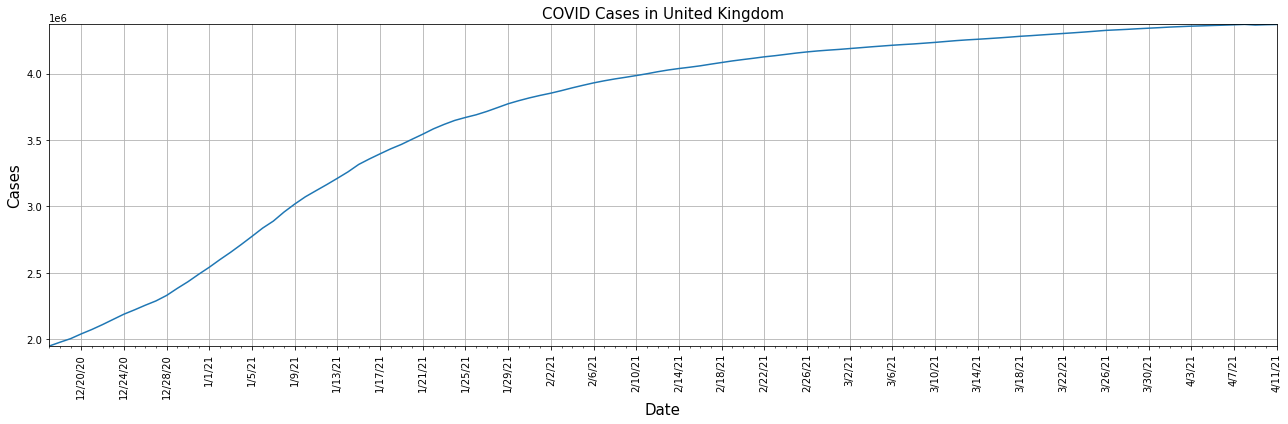

In [75]:
Stats.plotIt('United Kingdom', 'Cases', 3, 4, 4)

Total COVID cases in the United Kingdom spiked sharply between late December 2020 and late January 2021, but have calmed since mid-February. 

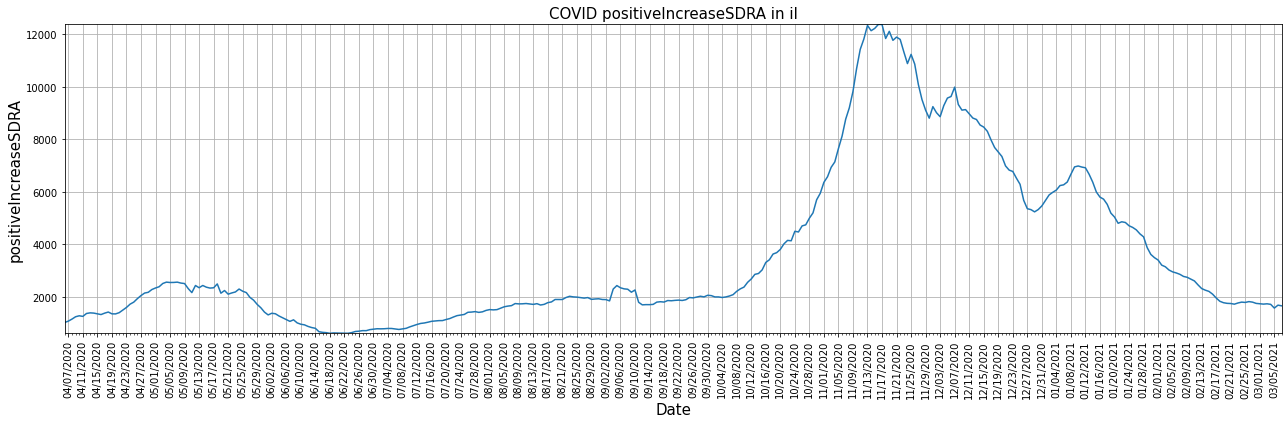

In [43]:
Stats.plotIt('il', 'positiveIncreaseSDRA', 12, 0, 0)

The second wave of COVID cases in Illinois started in early October 2020 and ended mid febrauary, peaking around the middle of November 2020.



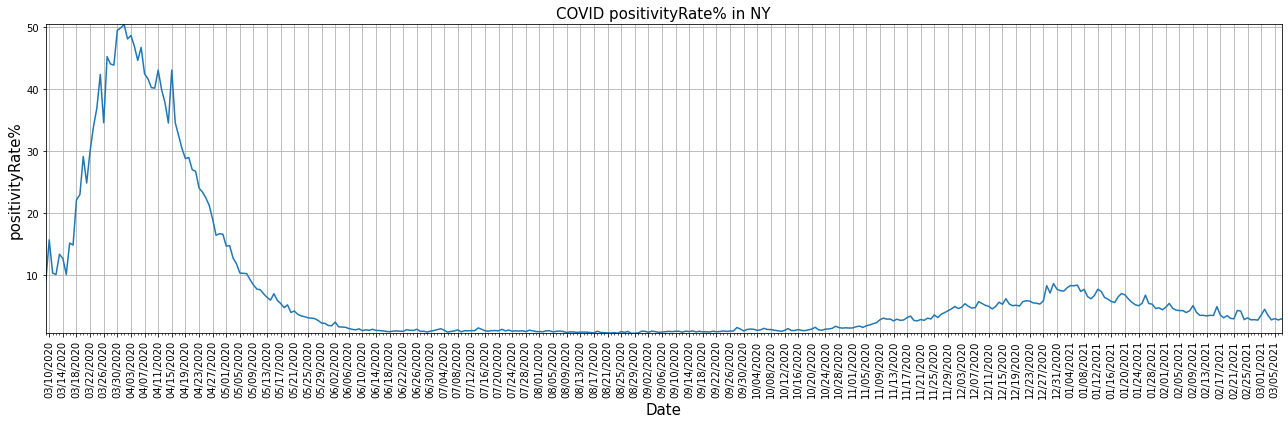

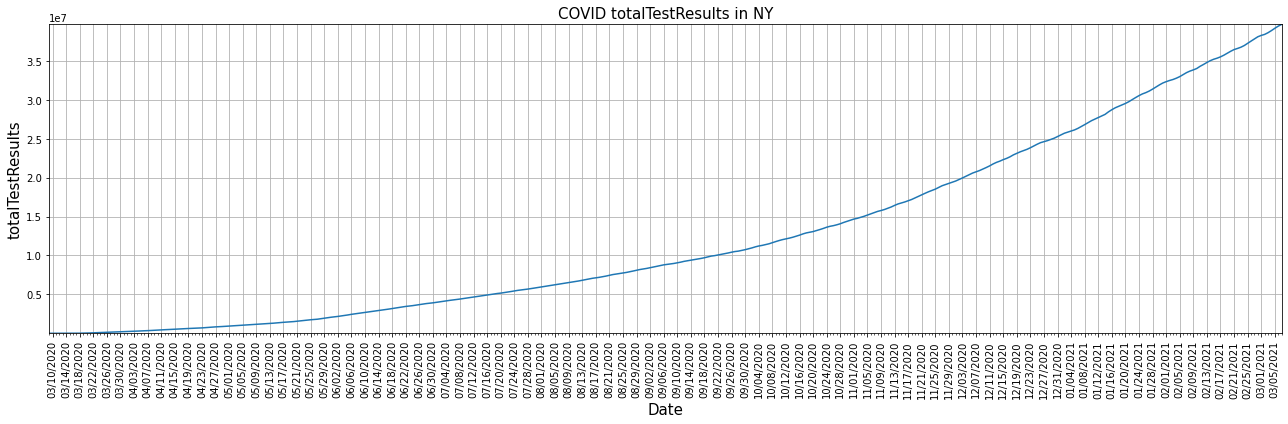

In [17]:
Stats.plotIt('ny', 'positivityRate%', 13, 0, 0)
Stats.plotIt('ny', 'totalTestResults', 13, 0, 0)

The positivity rate of COVID testing was extraodinarily high in New York state from the beginning of the pandemic to early June 2020. As the amount of tests conducted sharply increased, the positivity rate sharply decreased until the beginning of Fall 2020. Then, a sharp increase in testing corresponded with a higher positivity rate, meaning an increase in positive cases could not be attributed to merely an increase in testing.  



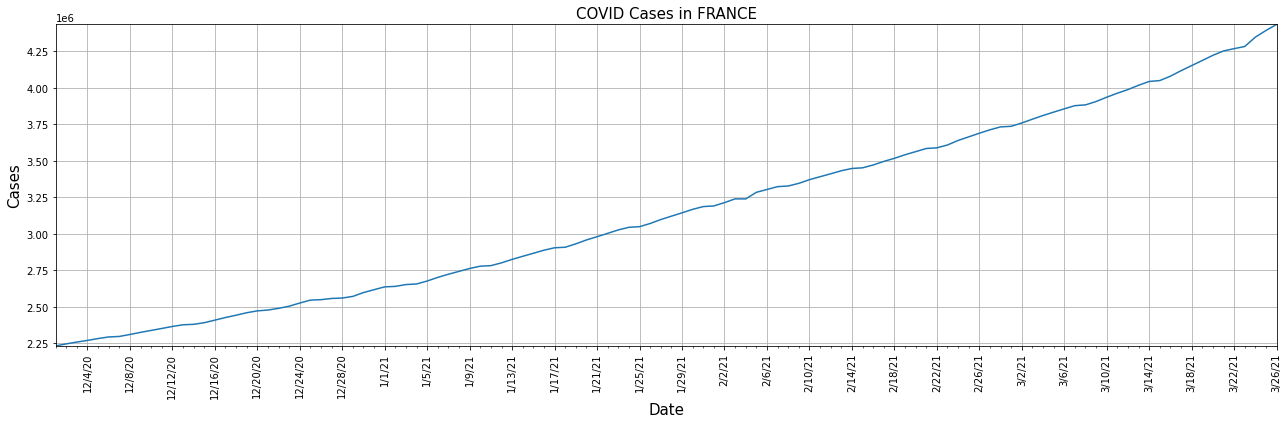

In [63]:
Stats.plotIt('France', 'Cases', 3, 4, 4)

While cases in the UK flattened in 2021, their neighbor to the South experienced steady growth in cases during this time.


Overlay two plots at a time to contextualize the rates of two variables using the same custom time frame as above.



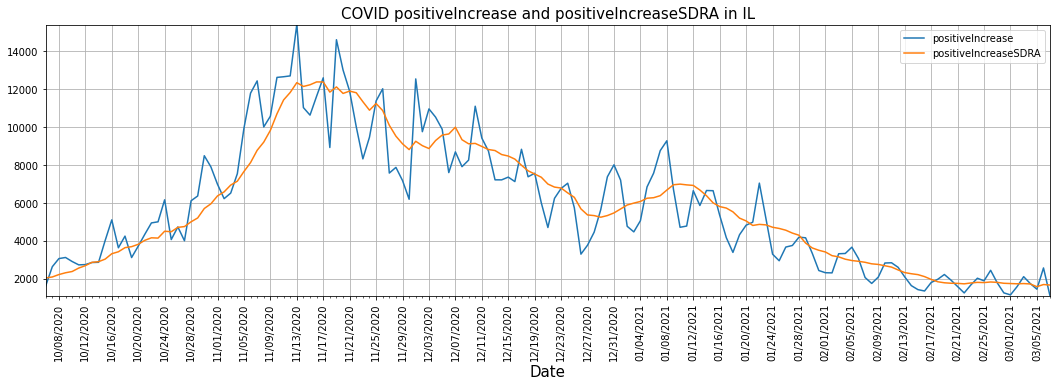

In [53]:
Stats.plotOverlay('il', 'positiveIncrease', 'positiveIncreaseSDRA', 4, 5, 6)

While the blue line shows the daily new cases, the orange line shows the daily new cases seven day rolling average. This provides a more clear picture of how quickly the amount of new cases are increasing or decreasing. 

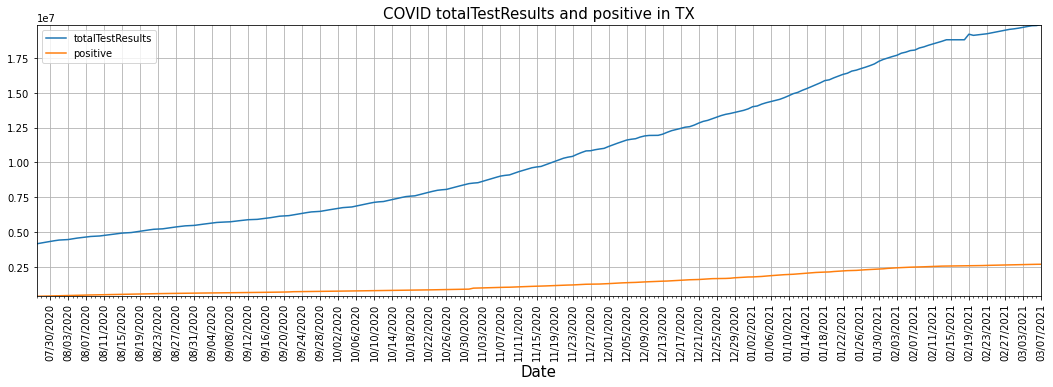

In [56]:
Stats.plotOverlay('tx', 'totalTestResults', 'positive', 8, 0, 0)

While the rate at which Texan COVID cases increased steepened from November 2020 to February 2021, this increase was not as steep as the overall increase in testing. 



This function computes linear regressions to predict future rate of change of a variable. One can change the starting date to modify scope. Also displays the coefficient of determination, slope, and sample size of the regression model.

r2 = 0.9528236529818478, slope = [-96.78954973], n=116


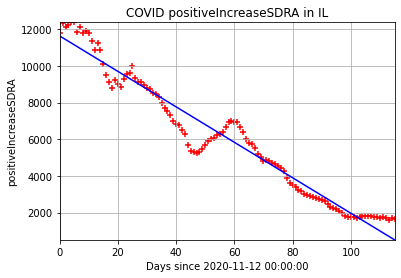

In [96]:
Stats.regressionLine('il', '11/12/2020', 'positiveIncreaseSDRA')

If November 14th 2020 (the peak of the second wave) is taken as a reference point, new Covid cases in Illinois follow a clear downward trend with a predicted decrease in daily cases of 96 for each passing day. 

r2 = 0.9004606552414782, slope = [4253.29892534], n=302


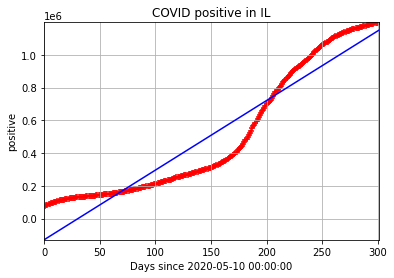

In [103]:
Stats.regressionLine('il', '5/10/2020', 'positive')

If May 10th 2020 is used as a reference point, the total cases in Illinois are on a steep upward trend with a predicted 4,253 new cases each day. 

r2 = 0.9133180843870975, slope = [455.14864338], n=244


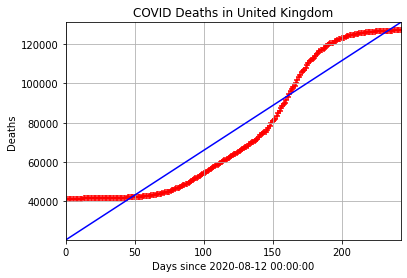

In [89]:
Stats.regressionLine('United Kingdom', '8/12/2020', 'Deaths')

The United Kingdom has a steeply increasing death count since August 12th, 2020, with a predicted increase of 455 deaths per day.

r2 = 0.7940490399637431, slope = [1103.9284841], n=447


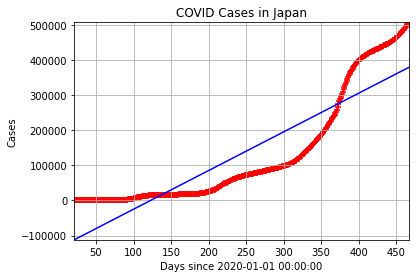

In [106]:
Stats.regressionLine('Japan', '01/01/2020', 'Cases')

COVID cases in Japan have been mostly steadily increasing since the start of the pandemic with an average rate of change of 1104 new cases each day. 

This next function computes a simple prediction of a given variable based on the linear regression formula. Coefficient of determination, slope, and sample size of the regression is also displayed.

r2 = 0.9015514574273572, slope = [4280.96647096], n=300


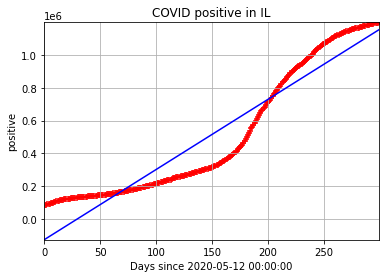

In [122]:
Stats.regressionLine('il', '05/12/2020', 'positive')

In [128]:
Stats.predictor('il', 'positive', '05/10/2020', '4/12/2021')

r2 = 0.9004606552414782, slope = [4253.29892534], n=302


1303483.9482506562

I chose a starting date of May 12th 2020 because of how well the best fit line fits the actual positivity count of Illinois while maintaining a large sample size. While my data source stopped collecting data at March 7th, 2021, the regression only overpredicted the total number of cases for 4/12/2021 by 21,000. This is a margin of error of less than 2%. The official Illinois Department of Health lists the total Covid cases as of 4/12/20210 as 1,282,205.